### Imports

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path

# Find directory that contains "src" (works from project/, code/, or subdirs)
_root = Path.cwd().resolve()
while _root != _root.parent and not (_root / "src").is_dir() and not (_root / "code" / "src").is_dir():
    _root = _root.parent
_code_dir = _root if (_root / "src").is_dir() else _root / "code"
if _code_dir.exists():
    sys.path.insert(0, str(_code_dir))

# import modules
from src.models import init_models, train_models, tune_params, save_models, save_results, DATA_DIR, FILE_NAME, OUTPUT_DIR
from src.plot import visualize_results

import warnings

warnings.filterwarnings(
    "ignore",
    message="`sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel`",
    category=UserWarning,
    module="sklearn.utils.parallel",
)

**Grid search**: Wider parameter ranges to explore the new dataset. For very large spaces you can use `search_type='random'` with `n_iter` in `tune_params()`.

### Config

In [2]:
LOAD = False
TUNE = True
# LOAD = True
# TUNE = False

### Load Data and Init models

In [3]:
df_model = pd.read_csv(DATA_DIR / FILE_NAME)

# limit to seasons 2010-2020
# df_model = df_model[df_model['SEASON'] >= 200]
df_model = df_model[df_model['SEASON'] <= 2022]

### Tune / Train models

In [ ]:
# Calculate scale_pos_weight from data
n_pos = (df_model['WL'] == 1).sum()
n_neg = (df_model['WL'] == 0).sum()
scale_pos_weight_val = round(n_neg / n_pos, 2)
print(f"Class balance: {n_pos} positive, {n_neg} negative -> scale_pos_weight = {scale_pos_weight_val}")

params_grid = {
    'Dummy Baseline': {
        'strategy': ['most_frequent']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1],
        'max_iter': [300],
        'random_state': [42],
        'solver': ['lbfgs'],
        'class_weight': ['balanced']
    },
    'Decision Tree': {
        'max_depth': [5, 8, 10, 12, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [15, 20],
        'max_features': ['sqrt'],
        'random_state': [42],
        'class_weight': ['balanced']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [100, 125, 150],
        'weights': ['uniform'],
        'algorithm': ['auto'],
        'metric': ['minkowski'],
        'n_jobs': [-1]
    },
    'Random Forest': {
        'n_estimators': [125, 150, 175],
        'max_depth': [8, 10, 12],
        'min_samples_split': [10],
        'min_samples_leaf': [2, 3],
        'max_features': ['sqrt'],
        'random_state': [42],
        'n_jobs': [-1],
        'class_weight': ['balanced']
    }
}

Class balance: 15057 positive, 10445 negative -> scale_pos_weight = 0.69


In [5]:
if not LOAD and TUNE:
    print("Tuning models")
    best_params = tune_params(params_grid, df_model, random_state=42)
    
    print("-"*100)
    for model_name, params in best_params.items():
        print(model_name)
        for param, value in params.items():
            print(f"\t{param}: {value}")
        print("-"*100)
    
    # best_params is dict of dict: { model_name: best_params }. Use to update init_models defaults or set_params on models.
    models = init_models(params = best_params, load = LOAD)
else:
    if LOAD: print("Loading models")
    models = init_models(load = LOAD)
    
    print("-"*100)
    for model in models:
        print(model)
        for param, value in models[model].get_params().items():
            print(f"\t{param}: {value}")
        print("-"*100)
    
print("Training models")
results = train_models(models, df_model, load = LOAD)

Tuning models

>>> Tuning 'Dummy Baseline' (1 configs, search_type=grid)


Dummy Baseline: 100%|██████████| 1/1 [00:00<00:00, 33.54config/s]

    best log_loss: 15.32422 -> {'strategy': 'most_frequent'}

>>> Tuning 'Logistic Regression' (2 configs, search_type=grid)



Logistic Regression: 100%|██████████| 2/2 [00:08<00:00,  4.07s/config]


    best log_loss: 0.66518 -> {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 300, 'random_state': 42, 'solver': 'lbfgs'}

>>> Tuning 'Decision Tree' (20 configs, search_type=grid)


Decision Tree: 100%|██████████| 20/20 [00:11<00:00,  1.76config/s]


    best log_loss: 0.68038 -> {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'random_state': 42}

>>> Tuning 'K-Nearest Neighbors' (3 configs, search_type=grid)


K-Nearest Neighbors: 100%|██████████| 3/3 [00:01<00:00,  1.90config/s]


    best log_loss: 0.65814 -> {'algorithm': 'auto', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 150, 'weights': 'uniform'}

>>> Tuning 'Random Forest' (18 configs, search_type=grid)


Random Forest: 100%|██████████| 18/18 [02:01<00:00,  6.73s/config]


    best log_loss: 0.65868 -> {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 175, 'n_jobs': -1, 'random_state': 42}
----------------------------------------------------------------------------------------------------
Dummy Baseline
	strategy: most_frequent
----------------------------------------------------------------------------------------------------
Logistic Regression
	C: 0.01
	class_weight: balanced
	max_iter: 300
	random_state: 42
	solver: lbfgs
----------------------------------------------------------------------------------------------------
Decision Tree
	class_weight: balanced
	max_depth: 5
	max_features: sqrt
	min_samples_leaf: 20
	min_samples_split: 2
	random_state: 42
----------------------------------------------------------------------------------------------------
K-Nearest Neighbors
	algorithm: auto
	metric: minkowski
	n_jobs: -1
	n_neighbors: 150
	weights: uniform
--------------

Seasons: 100%|██████████| 18/18 [00:29<00:00,  1.64s/season]


### Save and visialize results

Saved 5 models to /home/spina/Desktop/units/ML/project/output/models
Results saved to /home/spina/Desktop/units/ML/project/output/results.csv

>>> Average Metrics by Model:
                     Accuracy      F1     AUC     FPR     FNR  Time_s
Model                                                                
Decision Tree          0.5936  0.5847  0.6196  0.4434  0.3795  0.0504
Dummy Baseline         0.5884  0.3703  0.5000  1.0000  0.0000  0.0012
K-Nearest Neighbors    0.6206  0.5407  0.6376  0.7459  0.1250  0.1471
Logistic Regression    0.6108  0.6056  0.6524  0.3876  0.3904  0.4283
Random Forest          0.6212  0.6020  0.6456  0.5075  0.2896  0.9282


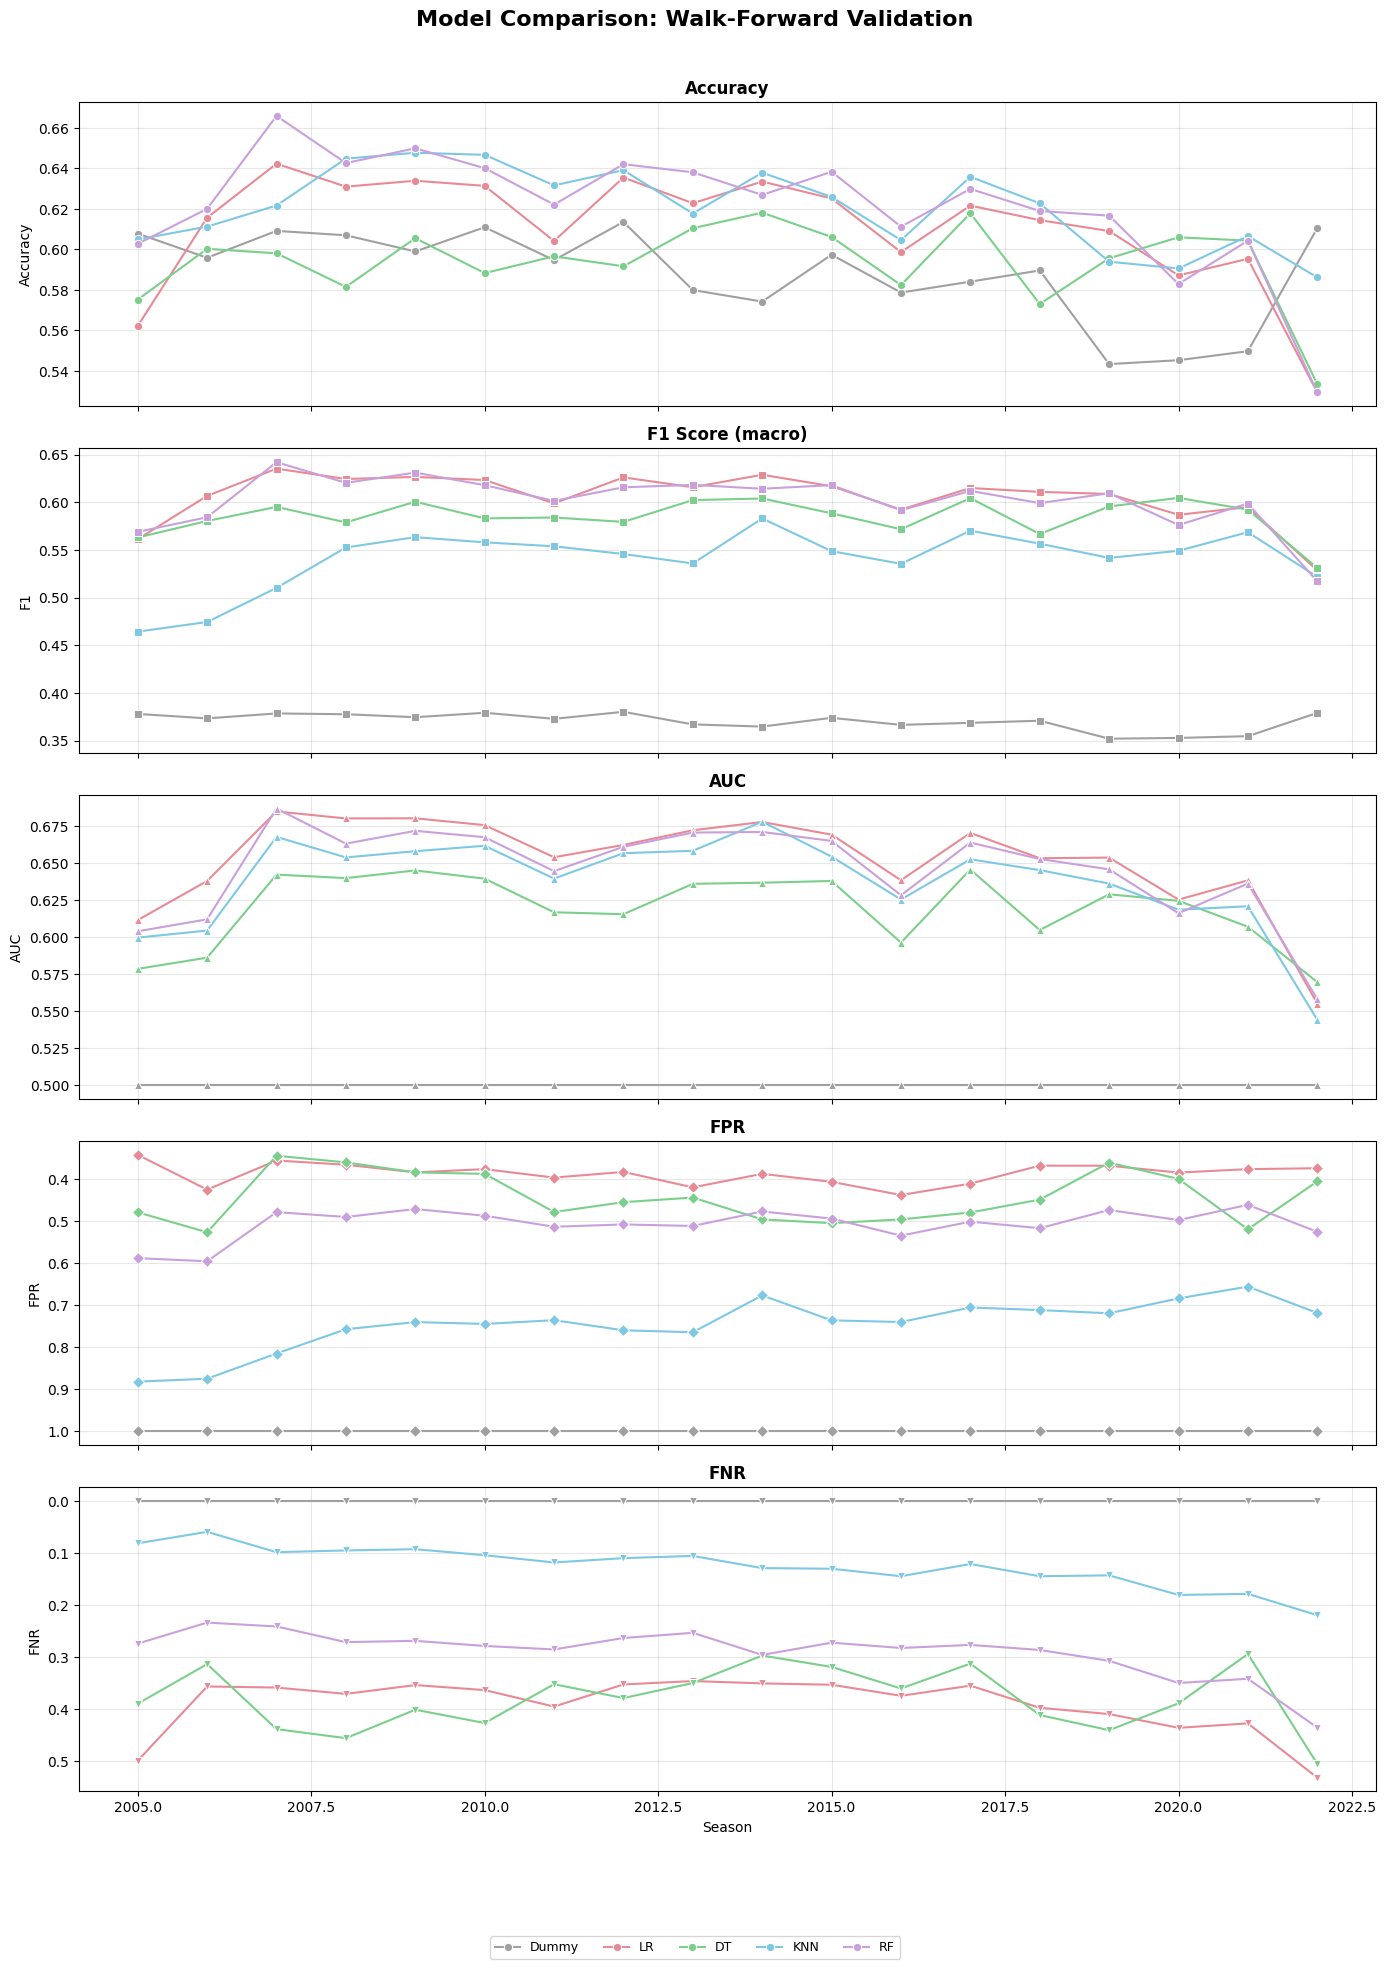

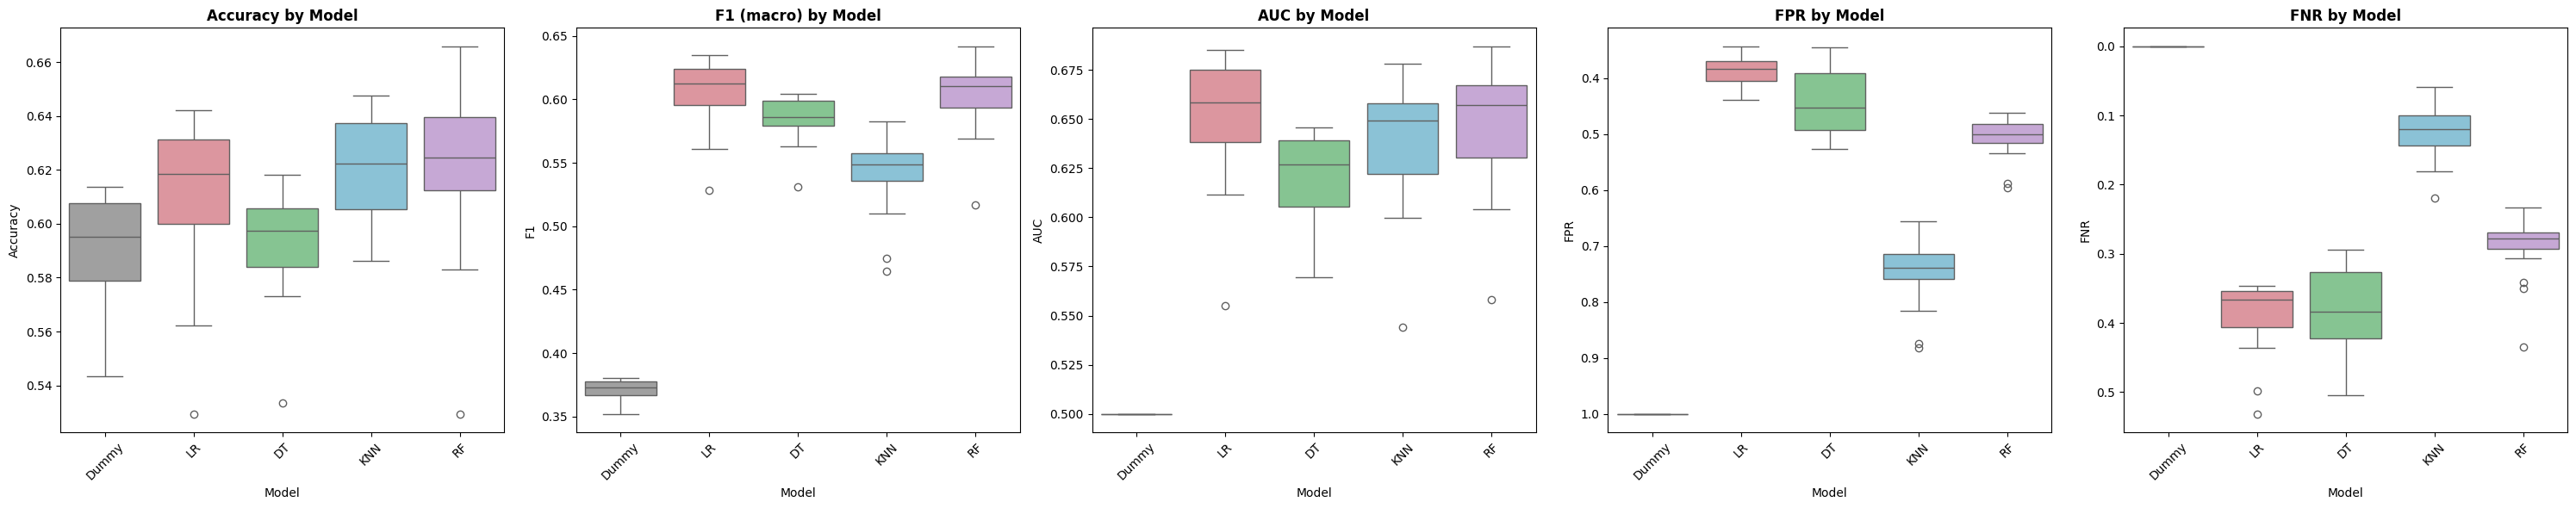


>>> Summary Statistics by Model:
                    Accuracy                              F1                  \
                        mean     std     min     max    mean     std     min   
Model                                                                          
Decision Tree         0.5936  0.0200  0.5335  0.6181  0.5847  0.0187  0.5311   
Dummy Baseline        0.5884  0.0228  0.5434  0.6136  0.3703  0.0092  0.3521   
K-Nearest Neighbors   0.6206  0.0197  0.5862  0.6477  0.5407  0.0312  0.4643   
Logistic Regression   0.6108  0.0287  0.5294  0.6423  0.6056  0.0264  0.5286   
Random Forest         0.6212  0.0301  0.5294  0.6659  0.6020  0.0281  0.5170   

                                AUC                             FPR          \
                        max    mean     std     min     max    mean     std   
Model                                                                         
Decision Tree        0.6045  0.6196  0.0242  0.5696  0.6458  0.4434  0.0590   
Dummy Bas

In [6]:
if not LOAD:
    save_models(models)
    save_results(results)
visualize_results(results, OUTPUT_DIR)